In [15]:
%%time
from numpy.linalg import svd as np_svd, lstsq as np_lstsq, qr as np_qr, pinv as np_pinv                
from numpy import finfo as np_finfo, divide as np_divide, dot as np_dot, multiply as np_multiply, \
                    einsum, square as np_square, newaxis as np_newaxis, log as np_log, sqrt as np_sqrt, \
                    arange as np_arange, array as np_array, argmax as np_argmax, sign as np_sign, \
                    abs as np_abs
from numba.types import Tuple, float32, float64, int32, int64, Array, UniTuple
from numba import njit, jit
from scipy.stats import t as tdist
import numpy as np

matrix32 = float32[:,:]
matrix64 = float64[:,:]
array32 = float32[:]
array64 = float64[:]
int32A = int32[:]
int64A = int64[:]

def column(a): return a[:,np_newaxis]
def row(a): return a[np_newaxism,:]

@njit( [ Tuple((matrix32, array32, matrix32))  (matrix32) ,
         Tuple((matrix64, array64, matrix64))  (matrix64) ] , fastmath = True, nogil = True)
def _svd(X):
    return np_svd(X, full_matrices = False)

@njit( [ UniTuple(matrix32, 2)  (matrix32) ,
         UniTuple(matrix64, 2)  (matrix64) ] , fastmath = True, nogil = True)
def _qr(X):
    return np_qr(X)


@njit( [ Tuple((array32, array32, int32, array32))  (matrix32, array32) ,
         Tuple((array64, array64, int64, array64))  (matrix64, array64) ,
         Tuple((array32, array32, int32, array32))  (matrix32, int32A) ,
         Tuple((array64, array64, int64, array64))  (matrix64, int64A) ] , fastmath = True, nogil = True)
def _lstsq(X, y):
    return np_lstsq(X, y.astype(X.dtype))

Wall time: 4.11 s


In [1]:
from torch import from_numpy as toTensor, svd as __svd, qr as __qr, einsum as t_einsum, \
    pinverse as __pinv, div as divide, transpose as __transpose, Tensor as typeTensor, \
    stack as __stack
from functools import wraps      
from numpy import finfo as np_finfo, einsum as np_einsum
from numpy import float32 as np_float32, float64 as np_float64, int32 as np_int32, int64 as np_int64
from scipy.linalg.lapack import clapack
from scipy.stats import t as tdist
use_numpy_einsum = True

def Tensor(*args):
    out = []
    for x in args:
        if type(x) is not typeTensor:
            out.append(  toTensor(x)  )
        else:
            out.append(  x  )
    return out

def Numpy(*args):
    out = []
    for x in args:
        if type(x) is typeTensor:
            out.append(  x.numpy()  )
        else:
            out.append(  x  )
    return out

def return_numpy(*args):
    result = Numpy(*args)
    if len(result) == 1:
        return result[0]
    else:
        return tuple(result)

def n2n(f):
    @wraps(f)
    def wrapper(*args, **kwargs):
        returned = f(*Tensor(*args), **kwargs)
        
        if type(returned) not in (tuple, list):
            returned = [returned]
        
        return return_numpy(*returned)
    return wrapper

def n2t(f):
    @wraps(f)
    def wrapper(*args, **kwargs):
        returned = f(*Tensor(*args), **kwargs)
        return returned
    return wrapper

def einsum(notation, *args, tensor = False):
    if use_numpy_einsum:
        args = Numpy(*args)
        out = np_einsum(notation, *args)
    else:
        args = Tensor(*args)
        try:
            out = t_einsum(notation, *args)
        except:
            out = t_einsum(notation, args)
    if tensor:
        return toTensor(out)
    return out

def T(X):
    if type(X) is not typeTensor:
        X = toTensor(X)
    if len(X.shape) == 1:
        return X.reshape(-1,1)
    return __transpose(X, 0, 1)

def ravel(y, X):
    return Tensor(y.ravel().astype( dtype(X) ))

def constant(X):
    return X.item()

def eps(X):
    try:
        return np_finfo(dtype(X)).eps
    except:
        return np_finfo(np_float64).eps
    
def dtype(tensor):
    if 'float32' in str(tensor.dtype): return np_float32
    elif 'float64' in str(tensor.dtype): return np_float64
    elif 'int32' in str(tensor.dtype): return np_int32
    elif 'int64' in str(tensor.dtype): return np_int64
    else: return np_float32
    
def stack(*args):
    if type(args[0]) is list:
        args = args[0]
    toStack = Tensor(*args)
    return __stack(toStack)

In [2]:
def t_svd(X):
    U, S, V = __svd(X, some = True)
    return U, S, T(V)
svd = n2n(t_svd)
_svd = n2t(t_svd)


def t_pinv(X):
    U, S, VT = _svd(X)
    cond = S < eps(X)*constant(S[0])
    _S = 1.0 / S
    _S[cond] = 0.0
    VT *= T(_S)
    return T(VT).matmul(T(U))
pinv = n2n(t_pinv)
_pinv = n2t(t_pinv)


def t_qr(X):
    return __qr(X)
qr = n2n(t_qr)
_qr = n2t(t_qr)


def qr_solve(X, y):
    '''
    theta =  R^-1 * QT * y
    '''
    Q, R = qr(X)
    check = 0
    if R.shape[0] == R.shape[1]:
        _R, check = clapack.strtri(R)
    if check > 0:
        _R = _pinv(R)
    Q, _R, R = Tensor(Q, _R, R)
    
    theta_hat = _R.matmul(   T(Q).matmul( ravel(y, Q) )   )
    return theta_hat


def svd_solve(X, y):
    '''
    theta =  V * S^-1 * UT * y
    '''
    U, S, VT = _svd(X)
    cond = S < eps(X)*constant(S[0])
    _S = 1.0 / S
    _S[cond] = 0.0
    VT *= T(_S)
    
    theta_hat = T(VT).matmul(  
                            T(U).matmul(  ravel(y, U)  )
                            )
    return theta_hat


def ridge_solve(X, y, alpha = 1):
    '''
                    S
    theta =   V --------- UT y 
                 S^2 + aI
    '''
    U, S, VT = _svd(X)
    cond = S < eps(X)*constant(S[0])
    _S = S / (S**2 + alpha)
    _S[cond] = 0.0
    VT *= T(_S)
    
    theta_hat = T(VT).matmul(  
                            T(U).matmul(  ravel(y, U)  )
                            )
    return theta_hat


def qr_stats(Q, R):
    '''
    XTX^-1  =  RT * R
    
    h = diag  Q * QT
    
    mean(h) used for normalized leverage
    '''
    XTX = T(R).matmul(R)
    _XTX = pinv(XTX)
    ## Einsum is slow in pytorch so revert to numpy version
    h = einsum('ij,ij->i', Q, Q )
    h_mean = h.mean()
    
    return _XTX, h, h_mean


def svd_stats(U, S, VT):
    '''
                  1
    XTX^-1 =  V ----- VT 
                 S^2
    
    h = diag U * UT
    
    mean(h) used for normalized leverage
    '''
    _S2 = 1.0 / (S**2)
    VS = T(VT) * _S2
    _XTX = VS.matmul(VT)
    h = einsum('ij,ij->i', U, U )
    h_mean = h.mean()
    
    return _XTX, h, h_mean


def ridge_stats(U, S, VT, alpha = 1):
    '''
                               S^2
    exp_theta_hat =  diag V --------- VT
                            S^2 + aI
                            
                                 S^2
    var_theta_hat =  diag V ------------- VT
                            (S^2 + aI)^2
    
                    1
    XTX^-1 =  V --------- VT
                S^2 + aI
                
                  S^2
    h = diag U --------- UT
                S^2 + aI
    
    mean(h) used for normalized leverage
    '''
    V = T(VT)
    S2 = S**2
    S2_alpha = S2 + alpha
    S2_over_S2 = S2 / S2_alpha
    
    VS = V * S2_over_S2
    exp_theta_hat = einsum('ij,ji->i', VS, VT )     # Same as VS.dot(VT)
    
    V_S2 = VS / S2_alpha  # np_divide(S2,  np_square( S2 + alpha ) )
    var_theta_hat = einsum('ij,ij->i',  V_S2  , V )   # Sams as np_multiply(   V,   V_S2 ).sum(1)
    
    _XTX = (V * (1.0 / S2_alpha )  ).matmul( VT )   # V  1/S^2 + a  VT
    
    h = einsum('ij,ij->i', (U * S2_over_S2), U )  # Same as np_multiply(  U*S2_over_S2, U ).sum(1)
    h_mean = h.mean()
    
    return exp_theta_hat, var_theta_hat, _XTX, h_mean

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

In [1]:
import numpy as np
from sklearn.datasets import make_classification
n = 1000000
p = 100
X, y = make_classification(random_state = 0, n_samples = n, n_features = p, n_classes = 10,
                          n_informative = int(p/3))
X = X.astype(np.float32)
results = [n,p]
y = y.astype(np.str)

In [5]:
X, Y = Tensor(X, y)

In [1]:
from hyperlearn.temp import addition

In [45]:
Parallel(addition)([1,5,1], [2,2,2], [3,3,3])

[[6, 10, 6], [1, 5, 1], [2, 2, 2]]

In [13]:
finalOutput

[[6, 10, 6], [1, 5, 1], [2, 2, 2]]

In [4]:
from hyperlearn.linalg import *
from hyperlearn.base import *


In [31]:
(X == 0).dtype is np.bool_

False

In [4]:
%%time
from hyperlearn.discriminant_analysis import QuadraticDiscriminantAnalysis
model = QuadraticDiscriminantAnalysis(n_jobs = -1)
model.fit(X, y)

Wall time: 9.05 s


In [5]:
%%time
model.predict(X)

Wall time: 13.2 s


array(['1', '9', '9', ..., '9', '8', '6'], dtype='<U1')

In [7]:
%%time
j = X - model.means_[0]
out = toTensor(j).matmul(model.scaled_rotations_[0])

Wall time: 1.02 s


In [14]:
%%time
mo

dict_keys(['reg_param', 'store_covariance', 'n_jobs', 'scalings_', 'rotations_', 'means_', 'log_scalings_', 'covariance_', 'scaled_rotations_', 'classes_', 'priors_'])

In [15]:
%%time
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
model = QuadraticDiscriminantAnalysis()
model.fit(X, y)

C:\Users\danie\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Wall time: 13.9 s


In [16]:
%%time
model.score(X, y)

Wall time: 40.3 s


0.940342

In [37]:
%%time
alpha = 0.001
a_1 = 1-alpha

class_priors = y.bincount().type(torch.float32) / X.shape[0]
classes = y.unique()

class_scalings = []; class_rotations = []; class_means = []; log_scalings = []

for x in classes:
    partial_X = X[y == x]
    partial_mean = partial_X.mean(0)
    partial_X -= partial_mean
    
    U, S, VT = _svd(partial_X)
    V = T(VT)
    scale = (S**2) / (partial_X.shape[0] -1)
    scale = alpha + (a_1 * scale)
    
    #partial_cov = (V * scale).matmul(VT)
    
    class_scalings.append(scale)
    log_scalings.append(scale.log().sum())
    class_rotations.append(V)
    class_means.append(partial_mean)
    
class_log_scalings = stack(log_scalings)
class_log_priors = class_priors.log()

Wall time: 46.9 ms


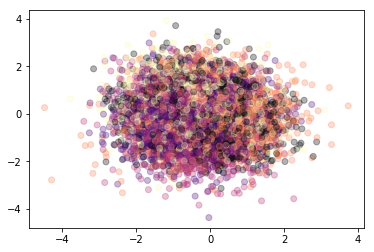

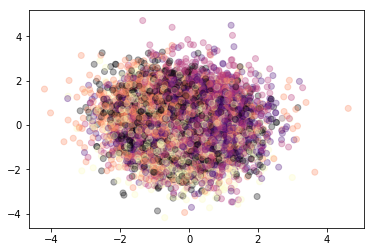

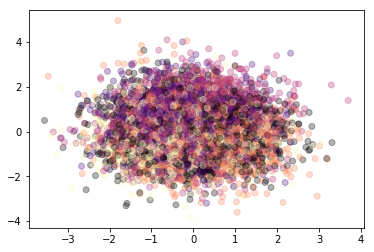

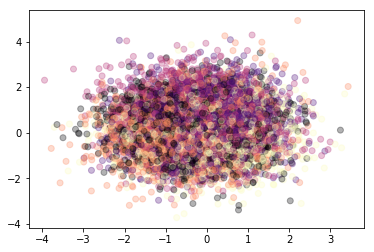

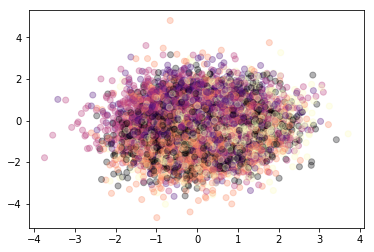

98.16
Wall time: 5.15 s


In [56]:
%%time
distances = []

for V, S, means in zip(class_rotations, class_scalings, class_means):
    partial_X = (X - means).matmul(   V/S**0.5   )
    
    plt.scatter(partial_X[:,0], partial_X[:,1], c = y, cmap = 'magma', alpha = 0.3)
    plt.show()
    distances.append(  einsum('ij,ij->i', partial_X, partial_X) )
    #distances.append(  (partial_X**2).sum(1)  )

distances = T(stack(distances))
decision = -0.5 * (distances + class_log_scalings) + class_log_priors

likelihood = (decision - T(decision.max(1)[0])).exp()
sum_softmax = T( einsum('ij->i', likelihood) )
#sum_softmax = T(likelihood.sum(1))
softmax = likelihood / sum_softmax

pred = classes.take(softmax.argmax(1)).numpy()
true = y.numpy()
print((pred == true).sum() / len(X) * 100)

tensor([-1.6074, -1.6074, -1.6094, -1.6084, -1.6145])

In [16]:
-0.5*(distances + class_log_scalings) + class_log_priors

tensor([[ -74.5080,  -98.6681,  -87.0466, -102.4116, -117.9962],
        [ -94.4381,  -92.7964, -116.9569,  -95.3064, -104.3241],
        [ -89.2804,  -75.4315, -106.4176,  -87.0239,  -87.4431],
        ...,
        [-115.2742,  -81.3762, -110.2471, -112.2464, -128.5372],
        [ -86.0973,  -73.8472, -128.8658,  -99.9822, -116.7335],
        [ -77.9924,  -92.7583,  -90.3370,  -99.5591, -101.7187]])

In [14]:
distances

tensor([[ 83.9927, 135.1069, 111.5717, 143.3374, 175.3822],
        [123.8528, 123.3635, 171.3923, 129.1269, 148.0380],
        [113.5375,  88.6338, 150.3137, 112.5619, 114.2760],
        ...,
        [165.5251, 100.5231, 157.9728, 163.0070, 196.4643],
        [107.1712,  85.4653, 195.2101, 138.4786, 172.8569],
        [ 90.9613, 123.2875, 118.1525, 137.6323, 142.8272]])

In [102]:
from keras.models import Sequential
from keras.layers import Dense

model = Sequential()
model.add(Dense(10, input_shape = (X.shape[1], ), activation = 'relu') )
model.add(Dense(5, activation = 'softmax'))

model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['acc'])
model.fit(X.numpy(), labels.type(torch.float).numpy(), epochs = 10, batch_size = 128)

Epoch 1/10
1000000/1000000 [==============================] - 19s 19us/step - loss: 1.1668 - acc: 0.5434
Epoch 2/10
 701312/1000000 [====================>.........] - ETA: 5s - loss: 1.1298 - acc: 0.5499

KeyboardInterrupt: 

In [158]:
from torch import nn, optim

model = nn.Sequential(
    nn.Linear(X.shape[1], 5),
#     nn.ReLU(),
#     nn.Linear(100, 5)
)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), weight_decay = 0.001, lr = 0.05)

labels = []
for i in y.unique():
    labels.append(y==i)
labels = T(stack(labels)).type(torch.LongTensor )

In [159]:
ys = y.type(torch.long)

In [160]:
for epoch in range(100):
    optimizer.zero_grad()
    outputs = model(X)
    loss = criterion(outputs, ys)
    loss.backward()
    optimizer.step()
    print((model(X).argmax(1) == ys).sum().type(torch.float) / len(X))

tensor(0.3815)
tensor(0.4731)
tensor(0.4957)
tensor(0.5058)
tensor(0.5151)
tensor(0.5238)
tensor(0.5284)
tensor(0.5292)
tensor(0.5281)
tensor(0.5274)
tensor(0.5262)
tensor(0.5231)
tensor(0.5191)
tensor(0.5168)
tensor(0.5193)
tensor(0.5248)
tensor(0.5292)
tensor(0.5309)
tensor(0.5320)
tensor(0.5337)
tensor(0.5367)
tensor(0.5382)
tensor(0.5374)
tensor(0.5363)
tensor(0.5356)
tensor(0.5359)
tensor(0.5379)
tensor(0.5406)
tensor(0.5432)
tensor(0.5456)
tensor(0.5472)
tensor(0.5478)
tensor(0.5483)
tensor(0.5486)
tensor(0.5484)
tensor(0.5476)
tensor(0.5469)
tensor(0.5464)
tensor(0.5464)
tensor(0.5478)
tensor(0.5491)
tensor(0.5503)
tensor(0.5511)
tensor(0.5516)
tensor(0.5521)
tensor(0.5525)
tensor(0.5530)
tensor(0.5529)
tensor(0.5529)
tensor(0.5528)
tensor(0.5525)
tensor(0.5522)
tensor(0.5519)
tensor(0.5521)
tensor(0.5522)
tensor(0.5525)
tensor(0.5525)
tensor(0.5525)
tensor(0.5525)
tensor(0.5526)
tensor(0.5526)
tensor(0.5527)
tensor(0.5527)
tensor(0.5527)
tensor(0.5529)
tensor(0.5530)
tensor(0.5

In [161]:
vars(model[0])

{'_backend': <torch.nn.backends.thnn.THNNFunctionBackend at 0x1f9241b30b8>,
 '_backward_hooks': OrderedDict(),
 '_buffers': OrderedDict(),
 '_forward_hooks': OrderedDict(),
 '_forward_pre_hooks': OrderedDict(),
 '_modules': OrderedDict(),
 '_parameters': OrderedDict([('weight', Parameter containing:
               tensor([[ 9.4933e-02, -2.7903e-02,  5.4143e-02, -3.8920e-02, -1.9413e-03,
                         2.0623e-03, -1.1931e-01,  1.4252e-03, -7.4351e-04, -2.5267e-04,
                         3.6054e-02, -2.1787e-03,  1.3744e-04, -9.8773e-02, -2.3283e-03,
                        -4.5737e-04, -4.2101e-02, -8.1032e-02,  2.0542e-02, -1.4072e-01,
                         5.0527e-03, -9.9426e-04,  4.7793e-03,  5.4804e-02, -1.0285e-01,
                         6.2512e-02, -2.2926e-04, -6.9780e-04,  1.6116e-03, -1.8794e-03,
                         1.7857e-03, -2.3572e-03, -3.1335e-03,  4.3728e-02,  2.2252e-02,
                         4.9687e-02,  3.1534e-03, -6.6565e-03, -2.2817e-03, 

In [ ]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(n_jobs = -1, multi_class = 'ovr')
model.fit(X, y)

C:\Users\danie\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1235: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


In [165]:
LogisticRegression()

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [18]:
%%time
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
model = QuadraticDiscriminantAnalysis(reg_param = 0.01)
model.fit(X, y)

C:\Users\danie\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Wall time: 13.1 s


In [23]:
400/2700

0.14814814814814814

In [21]:
%%time
pred = model.predict(X)

Wall time: 20.6 s


In [40]:
%%time
(pred == y).sum().item() / len(X)

Wall time: 11 ms


0.966448

In [74]:
class_scalings[0].numpy().round(1), model.scalings_[0].round(1)

(array([191.2, 102.2,  27.9,  26.3,  23.7,  22.7,  21.3,  19. ,  18.3,
         17.7,  14.6,  13.4,  12.4,  11.9,  11.5,  10.6,   9.7,   9.2,
          8.2,   7.9,   7.3,   6.6,   6. ,   5.4,   5.3,   4.7,   4.4,
          3.9,   3.6,   3.1,   2.4,   2.2,   1.5,   1. ,   1. ,   1. ,
          1. ,   1. ,   1. ,   1. ,   1. ,   1. ,   1. ,   1. ,   1. ,
          1. ,   1. ,   1. ,   1. ,   1. ,   1. ,   1. ,   1. ,   1. ,
          1. ,   1. ,   1. ,   1. ,   1. ,   1. ,   1. ,   1. ,   1. ,
          1. ,   1. ,   1. ,   1. ,   1. ,   1. ,   1. ,   1. ,   1. ,
          1. ,   1. ,   1. ,   1. ,   1. ,   1. ,   1. ,   1. ,   1. ,
          1. ,   1. ,   1. ,   1. ,   1. ,   1. ,   1. ,   1. ,   1. ,
          1. ,   1. ,   1. ,   1. ,   1. ,   1. ,   1. ,   1. ,   0. ,
          0. ], dtype=float32),
 array([191.2, 102.2,  27.9,  26.3,  23.7,  22.7,  21.3,  19. ,  18.3,
         17.7,  14.6,  13.4,  12.4,  11.9,  11.5,  10.6,   9.7,   9.2,
          8.2,   7.9,   7.3,   6.6,   6. ,   

array([1.91236081e+02, 1.02177347e+02, 2.79099406e+01, 2.63137360e+01,
       2.36696019e+01, 2.26543316e+01, 2.12867894e+01, 1.89890166e+01,
       1.82584292e+01, 1.77034717e+01, 1.46399046e+01, 1.34175341e+01,
       1.23685021e+01, 1.19065338e+01, 1.14762314e+01, 1.06366875e+01,
       9.74952124e+00, 9.19822732e+00, 8.16647519e+00, 7.90105685e+00,
       7.25116195e+00, 6.56587641e+00, 6.04448515e+00, 5.43551897e+00,
       5.33710049e+00, 4.66251251e+00, 4.44624247e+00, 3.92265597e+00,
       3.57316824e+00, 3.05495649e+00, 2.39681200e+00, 2.22889686e+00,
       1.52379344e+00, 1.03675699e+00, 1.03152683e+00, 1.03137186e+00,
       1.03009073e+00, 1.02742663e+00, 1.02552415e+00, 1.02439188e+00,
       1.02273555e+00, 1.02192227e+00, 1.02062420e+00, 1.01943486e+00,
       1.01895835e+00, 1.01781928e+00, 1.01748398e+00, 1.01661803e+00,
       1.01588239e+00, 1.01557686e+00, 1.01385007e+00, 1.01304723e+00,
       1.01214038e+00, 1.01025770e+00, 1.00882902e+00, 1.00760086e+00,
      

In [25]:
%%time
size = len(X)
x = torch.randperm(size)

x_train, x_test = X[x].chunk(2)
y_train, y_test = y[x].chunk(2)
size = len(x_test)

y_true = y_test.numpy()
class_priors = y_train.bincount().type(torch.float32) / x_train.shape[0]
class_log_priors = class_priors.log()

classes = y_train.unique()

scalings = []
rotations = []
means = []
log_scalings = []

for x in classes:
    partial_X = x_train[y_train == x, :]
    partial_mean = partial_X.mean(0)
    partial_X -= partial_mean
    
    U, S, VT = _svd(partial_X)
    V = T(VT)
    scale = (S**2) / (partial_X.shape[0] -1)
    
    scalings.append(scale)
    rotations.append(V)
    means.append(partial_mean)

    
scores = []
alphas = np.arange(0.001, 1, 0.1)

partials = []
for x in class_means:
    partials.append( x_test - x )
    
for alpha in alphas:
    log_scalings = []
    distances = []
    
    a_1 = 1 - alpha
    
    for partial_X, V, S in zip(partials, rotations, scalings):
        scale = alpha + (a_1 * S)
        log_scalings.append(scale.log().sum())
        
        partial_X = partial_X.matmul(   V/(scale**0.5)   )
        
        #distances.append(   (partial_X**2).sum(1)   )
        distances.append(   einsum('ij,ij->i', partial_X, partial_X)   )
    
    class_log_scalings = stack(log_scalings)
    distances = T(stack(distances))
    decision = -0.5 * (distances + class_log_scalings) + class_log_priors

    likelihood = (decision - T(decision.max(1)[0])).exp()
    
    sum_softmax = T(likelihood.sum(1))
    #sum_softmax = T(toTensor(einsum('ij->i', likelihood)))
    softmax = likelihood / sum_softmax

    pred = classes.take(softmax.argmax(1)).numpy()
    scores.append((pred == y_true).sum()/size)
scores = np.array(scores)

Wall time: 27.6 s


In [29]:
alphas[scores.argmax()]

0.001

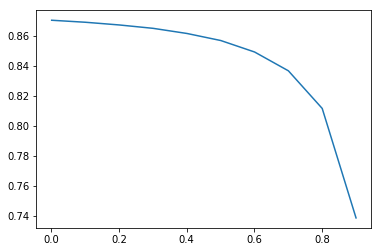

In [28]:
plt.plot(alphas, scores)

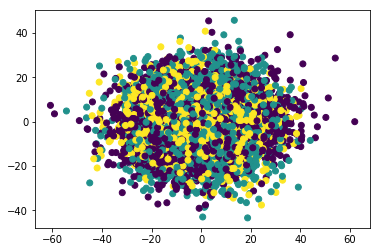

In [39]:
pcaed = model.transform(centered)
plt.scatter(x = pcaed[:,0], y = pcaed[:,1], c = y)

array([[28713,  2500,  2090],
       [  770, 31666,   882],
       [  574,   559, 32246]], dtype=int64)

In [211]:
if self.priors is None:
            self.priors_ = np.bincount(y) / float(n_samples)
        else:
            self.priors_ = self.priors

        cov = None
        store_covariance = self.store_covariance or self.store_covariances
        if self.store_covariances:
            warnings.warn("'store_covariances' was renamed to store_covariance"
                          " in version 0.19 and will be removed in 0.21.",
                          DeprecationWarning)
        if store_covariance:
            cov = []
        means = []
        scalings = []
        rotations = []
        for ind in xrange(n_classes):
            Xg = X[y == ind, :]
            meang = Xg.mean(0)
            means.append(meang)
            if len(Xg) == 1:
                raise ValueError('y has only 1 sample in class %s, covariance '
                                 'is ill defined.' % str(self.classes_[ind]))
            Xgc = Xg - meang
            # Xgc = U * S * V.T
            U, S, Vt = np.linalg.svd(Xgc, full_matrices=False)
            rank = np.sum(S > self.tol)
            if rank < n_features:
                warnings.warn("Variables are collinear")
            S2 = (S ** 2) / (len(Xg) - 1)
            S2 = ((1 - self.reg_param) * S2) + self.reg_param
            if self.store_covariance or store_covariance:
                # cov = V * (S^2 / (n-1)) * V.T
                cov.append(np.dot(S2 * Vt.T, Vt))
            scalings.append(S2)
            rotations.append(Vt.T)
        if self.store_covariance or store_covariance:
            self.covariance_ = cov
        self.means_ = np.asarray(means)
        self.scalings_ = scalings
        self.rotations_ = rotations
        return self

(array([[ 0.00285238, -0.00180336, -0.00291758, ..., -0.00407018,
          0.00237019,  0.00326035],
        [-0.00126421, -0.00241049,  0.00180534, ...,  0.00702247,
          0.00121643,  0.00310683],
        [ 0.00154274, -0.00266836,  0.00125294, ...,  0.0015607 ,
          0.00325905,  0.00586992],
        ...,
        [ 0.0046875 , -0.00208417,  0.00215589, ...,  0.00193842,
          0.00137759, -0.00389461],
        [-0.00139884, -0.00113583, -0.00239184, ..., -0.00518235,
          0.00094862,  0.00200532],
        [-0.00267318,  0.00227622, -0.00503509, ...,  0.00091144,
         -0.0020249 ,  0.00243085]]),
 array([4.47484907e+02, 4.35157052e+02, 3.25602160e+02, 3.25316640e+02,
        3.24987069e+02, 3.24634950e+02, 3.24033230e+02, 3.23825090e+02,
        3.23621969e+02, 3.23220017e+02, 3.23168520e+02, 3.22871438e+02,
        3.22689602e+02, 3.22635600e+02, 3.22502287e+02, 3.22422487e+02,
        3.21876817e+02, 3.21763563e+02, 3.21720353e+02, 3.21391735e+02,
        3.211

(array([[ 0.26828295, -0.48459633, -0.28348974, ...,  0.06128969,
         -0.37634071, -0.41134801],
        [-1.49184348,  0.94191838, -0.08449214, ...,  0.07240107,
          0.75658954,  1.04461582],
        [ 1.05758349,  0.13732633,  0.64605947, ...,  0.21777248,
         -0.69824594, -0.65786386],
        ...,
        [-0.74160985,  0.5440582 ,  0.57111656, ..., -1.70962913,
          1.51377675,  2.07027576],
        [ 0.60922737,  1.71082517, -0.8198716 , ..., -0.50819216,
         -0.87034515, -0.65203147],
        [-2.65453755,  1.67812103,  0.91308847, ..., -0.18156969,
          0.91924526,  1.62613369]]), array([0, 0, 1, ..., 1, 0, 0]))

In [118]:
U, S, VT = _svd(X)
Q, R = _qr(X)

In [157]:
%%time
ridge_stats(U, S, VT)

Wall time: 79.6 ms


(array([0.9998792 , 0.49981493, 0.99997   , 0.9971006 , 0.9998799 ,
        0.99999446, 0.9998798 , 0.99987954, 0.9998791 , 0.9998798 ,
        0.99998283, 0.99988   , 0.99987984, 0.99988   , 0.99987996,
        0.99987954, 0.99987954, 0.99987906, 0.99988043, 0.99987966,
        0.99987954, 0.9998789 , 0.99987996, 0.9998795 , 0.99988025,
        0.9998802 , 0.9998797 , 0.9998801 , 0.99987954, 0.9998801 ,
        0.9998796 , 0.9998791 , 0.9998792 , 0.9998797 , 0.99987906,
        0.9998805 , 0.9998797 , 0.99988   , 0.9998799 , 0.9998794 ,
        0.9998802 , 0.9998806 , 0.99988014, 0.99988014, 0.99988043,
        0.9998794 , 0.99988055, 0.9998799 , 0.99987954, 0.99988014,
        0.9998795 , 0.9998796 , 0.99987984, 0.99987984, 0.9998794 ,
        0.99988043, 0.9998793 , 0.99987984, 0.9998801 , 0.99987984,
        0.99988025, 0.9998797 , 0.99988014, 0.9998796 , 0.99988   ,
        0.9998799 , 0.99988025, 0.9998793 , 0.99987966, 0.99987966,
        0.9998799 , 0.99988025, 0.99987924, 0.99

In [130]:
ridge_stats(U, S, VT)

(array([0.9998792 , 0.49981493, 0.99997   , 0.9971006 , 0.9998799 ,
        0.99999446, 0.9998798 , 0.99987954, 0.9998791 , 0.9998798 ,
        0.99998283, 0.99988   , 0.99987984, 0.99988   , 0.99987996,
        0.99987954, 0.99987954, 0.99987906, 0.99988043, 0.99987966,
        0.99987954, 0.9998789 , 0.99987996, 0.9998795 , 0.99988025,
        0.9998802 , 0.9998797 , 0.9998801 , 0.99987954, 0.9998801 ,
        0.9998796 , 0.9998791 , 0.9998792 , 0.9998797 , 0.99987906,
        0.9998805 , 0.9998797 , 0.99988   , 0.9998799 , 0.9998794 ,
        0.9998802 , 0.9998806 , 0.99988014, 0.99988014, 0.99988043,
        0.9998794 , 0.99988055, 0.9998799 , 0.99987954, 0.99988014,
        0.9998795 , 0.9998796 , 0.99987984, 0.99987984, 0.9998794 ,
        0.99988043, 0.9998793 , 0.99987984, 0.9998801 , 0.99987984,
        0.99988025, 0.9998797 , 0.99988014, 0.9998796 , 0.99988   ,
        0.9998799 , 0.99988025, 0.9998793 , 0.99987966, 0.99987966,
        0.9998799 , 0.99988025, 0.99987924, 0.99

In [48]:
einsum('ij,ij->i', (U, U) )

tensor([0.0010, 1.0000, 0.0010,  ..., 0.0011, 0.0010, 0.0010])

In [43]:
np.einsum('ij,ij->i', UU, UU)

array([9.7439776e-04, 1.0000075e+00, 1.0168841e-03, ..., 1.0643535e-03,
       1.0059868e-03, 9.9848665e-04], dtype=float32)

In [37]:
UU, SS, VTVT = svd(X)

In [5]:
%%timeit -n3 -r1
U, S, VT = svd(X)
U = S = VT = None
gc.collect()

6.61 s ± 0 ns per loop (mean ± std. dev. of 1 run, 3 loops each)


In [17]:
%%timeit  -n3 -r1
Q, R = qr(X)
Q = R = None
gc.collect()

NameError: name 'gc' is not defined

In [40]:
u, s, vt =_svd(X)

In [51]:
%%time
u.matmul(torch.diag(s))

Wall time: 64.9 ms


tensor([[-4.8305,  0.0896,  0.1410,  ...,  0.4134, -0.5159, -0.0516],
        [-5.3489, -0.4584,  0.1231,  ..., -0.1123, -0.3316,  0.3531],
        [-5.5722,  0.2772, -0.1261,  ..., -0.0927, -0.2427,  0.3173],
        ...,
        [-4.9269, -0.1074, -0.2535,  ..., -0.2038,  0.1781,  0.3742],
        [-5.4743, -0.1601, -0.4688,  ...,  0.2988, -0.2193, -0.1242],
        [-5.0631, -0.0320,  0.5048,  ...,  0.2033,  0.4872,  0.0115]])

In [86]:
    max_U = np_argmax(np_abs(U), axis = 0)
    signs = np_sign(U[max_U, range(U.shape[1])])
    U *= signs
    VT *= signs[:, np_newaxis]

Wall time: 342 ms


tensor([[ 4.1779e-05, -6.1478e-05,  9.6094e-06,  ...,  4.6571e-05,
          1.3584e-05,  7.6849e-06],
        [-3.8099e-05,  3.0917e-05,  1.4614e-05,  ..., -1.3449e-06,
          2.6788e-06, -9.8037e-06],
        [-3.2145e-05,  4.8340e-05, -1.3717e-05,  ...,  5.6451e-05,
          7.7551e-06, -3.0078e-05],
        ...,
        [ 3.5836e-05,  1.5637e-05,  4.2711e-06,  ...,  5.7561e-05,
         -6.1811e-05,  2.8201e-05],
        [-1.3800e-05, -1.5572e-05,  4.7865e-05,  ...,  1.3712e-05,
         -9.4109e-06, -3.7873e-05],
        [ 6.8863e-06, -6.2639e-05,  1.9749e-05,  ..., -5.5498e-05,
          6.6020e-06, -1.1216e-05]])

In [85]:
%%time
_pinv(Tensor(X))

Wall time: 439 ms


tensor([[ 4.1779e-05, -6.1478e-05,  9.6094e-06,  ...,  4.6571e-05,
          1.3584e-05,  7.6849e-06],
        [-3.8099e-05,  3.0917e-05,  1.4614e-05,  ..., -1.3449e-06,
          2.6788e-06, -9.8037e-06],
        [-3.2145e-05,  4.8340e-05, -1.3717e-05,  ...,  5.6451e-05,
          7.7551e-06, -3.0078e-05],
        ...,
        [ 3.5836e-05,  1.5637e-05,  4.2711e-06,  ...,  5.7561e-05,
         -6.1811e-05,  2.8201e-05],
        [-1.3800e-05, -1.5572e-05,  4.7865e-05,  ...,  1.3712e-05,
         -9.4109e-06, -3.7873e-05],
        [ 6.8863e-06, -6.2639e-05,  1.9749e-05,  ..., -5.5498e-05,
          6.6020e-06, -1.1216e-05]])

In [ ]:
    U, S, VT = np_svd(X, full_matrices = False)
    cond =  S < np_finfo(X.dtype).eps*S[0] 
    S = np_divide(1.0, S)
    S[cond] = 0.0
    VT *= S.reshape(-1,1)
    return np_dot(VT.T, U.T)

In [67]:
%%time


Wall time: 596 ms


In [66]:
%%time
_pinv(X)

Wall time: 817 ms


tensor([[ 2.6104e-05, -1.4065e-05,  5.0083e-05,  ..., -1.8711e-05,
          2.7796e-05, -5.7680e-05],
        [ 9.7420e-06,  6.5235e-05,  3.4058e-05,  ...,  1.8251e-05,
         -1.2264e-05,  4.5283e-05],
        [-3.1893e-06,  2.6190e-05,  3.4621e-05,  ...,  5.9454e-05,
          4.0273e-05, -5.7446e-05],
        ...,
        [-4.1714e-05, -1.8986e-05,  1.8801e-05,  ...,  5.3823e-05,
          5.4447e-05,  5.8289e-06],
        [ 5.0664e-05, -4.6687e-05,  1.3481e-05,  ..., -2.2722e-06,
          4.2622e-05,  1.5753e-05],
        [-4.7990e-05, -1.1698e-06, -1.9074e-06,  ...,  4.1397e-05,
          1.3254e-05,  5.0063e-05]], dtype=torch.float64)

In [30]:
torch.diag(_S)

tensor([[0.0006, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0106, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0106,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0113, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0113, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0113]],
       dtype=torch.float64)

In [3]:
import numpy as np

X = np.random.random((100000,100))
X = X.astype(dtype = np.float32)
# X = Tensor(X)

In [3]:
%%time
X = Tensor(X)

Wall time: 50.2 ms


In [18]:
%%timeit
svd(X, some = True)

323 ms ± 22.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [27]:
with tf.Session() as sess:
    sess.run(init)
tf.matmul( tf.multiply(U, S) , V, transpose_b = True)

NameError: name 'init' is not defined

In [5]:
Xt = nn.Tensor(X)

In [6]:
%%time
U, S, V = nn.svd(Xt)

Wall time: 293 ms


In [23]:
tf.transpose(V)

<tf.Tensor 'transpose:0' shape=(100, 100) dtype=float64>

In [9]:
R

tensor([[-577.3033, -433.1046, -433.0701,  ..., -432.9970, -433.0812,
         -433.7284],
        [   0.0000, -381.6229, -163.2410,  ..., -163.4937, -163.9342,
         -163.4928],
        [   0.0000,    0.0000, -344.9677,  ..., -103.0842, -103.2758,
         -103.6988],
        ...,
        [   0.0000,    0.0000,    0.0000,  ..., -290.0645,   -3.0696,
           -3.1640],
        [   0.0000,    0.0000,    0.0000,  ...,    0.0000,  289.9319,
            2.7177],
        [   0.0000,    0.0000,    0.0000,  ...,    0.0000,    0.0000,
          289.9929]])

In [7]:
%%timeit -n3 -r1
U, S, VT = _svd(X)
U = S = VT = None
gc.collect()

9.37 s ± 0 ns per loop (mean ± std. dev. of 1 run, 3 loops each)


In [17]:
%%timeit -n3 -r1
Q, R = _qr(X)
Q = R = None
gc.collect()

3.46 s ± 0 ns per loop (mean ± std. dev. of 1 run, 3 loops each)
